In [1]:
# Generative Adversarial Network: Training

import multiprocessing

CONFIG = {
    # For repeatibility we will fix the random seed
    "manual_seed": 42,
    # This defines a set of augmentations we will perform, see below
    "policy": "color,translation",  #,cutout
    # Dimension of the latent space
    "latent_dimension": 256,
    # Batch size for training
    "batch_size": 256,
    # Number of epochs. We will use 1200 epochs which corresponds to 
    # approximately 20 min of training
    "n_epochs": 1000,
    # Input images will be resized to this, the generator will generate
    # images with this size
    "image_size": 32,  # 32x32 pixels
    # Number of channels in the input images
    "num_channels": 3,  # RGB
    # Learning rate
    "lr": 0.002,
    # Momentum for Adam: in GANs you want to use a lower momentum to
    # allow the Generator and the Discriminator to interact quicker
    "beta1": 0.7,
    # Number of feature maps in each layer of the Generator
    "g_feat_map_size": 64,
    # Number of feature maps in each layer of the Discriminator
    "d_feat_map_size": 64,
    # Where to save the data
    "data_path": "data/CIFAR10Cars/",
    # Number of workers to use to load the data
    "workers": multiprocessing.cpu_count(),
    # We will display progress every "save_iter" epochs
    "save_iter": 10,
    # Where to save the progress
    "outdir": "stanford_cars_gan_b128",
    # Unused
    "clip_value": 0.01
}

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [3]:
import random
import torch

random.seed(CONFIG['manual_seed'])
torch.manual_seed(CONFIG['manual_seed'])
torch.use_deterministic_algorithms(True)

In [4]:
import argparse
import json
from pathlib import Path
from helpers import get_positive_labels
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

In [5]:
from data import get_dataloader
from generator import Generator
from discriminator import Discriminator
from helpers import initialize_weights

from diff_augment import DiffAugment

from viz import training_tracking, visualize_batch
from IPython.display import clear_output
import matplotlib.pyplot as plt

from ema_pytorch import EMA

import time
import tqdm


In [6]:
# Create the output directory
output_dir = Path(CONFIG["outdir"])
output_dir.mkdir(parents=True, exist_ok=True)

# Save the configuration
with open(output_dir / " config.json", "w") as f:
    json.dump(CONFIG, f, indent=4)

# Make sure CUDA is available (i.e. the GPU is setup correctly)
assert torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
device

device(type='cuda', index=0)

Using 32 workers
Total number of examples: 6000


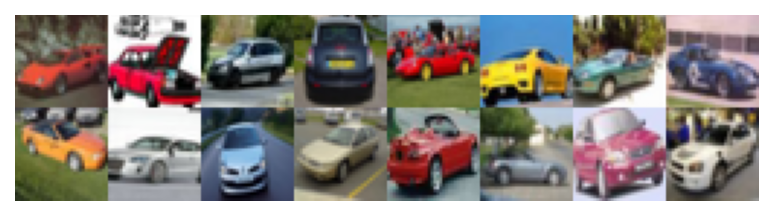

In [8]:
# Input dataset: Real data
# Get data loader
dataloader = get_dataloader(
    CONFIG["data_path"],
    CONFIG["image_size"],
    CONFIG["batch_size"],
    CONFIG["workers"]
)
print(f"Total number of examples: {len(dataloader.dataset)}")
visualize_batch(next(iter(dataloader))[0][:16])

In [9]:
# Generator
G = Generator(
    CONFIG["image_size"],
    CONFIG["latent_dimension"],
    CONFIG["g_feat_map_size"],
    CONFIG["num_channels"]
).to(device)

print(G)

Generator(
  (model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Identity()
      (2): Tanh()
    )
  )
)


In [10]:
# Generate an image from Latent space (Noisy image as we haven't trained yet)
latent = torch.randn(1, CONFIG['latent_dimension'], 1, 1).to(device)
fake_img = G(latent)
print(fake_img.shape)

torch.Size([1, 3, 32, 32])


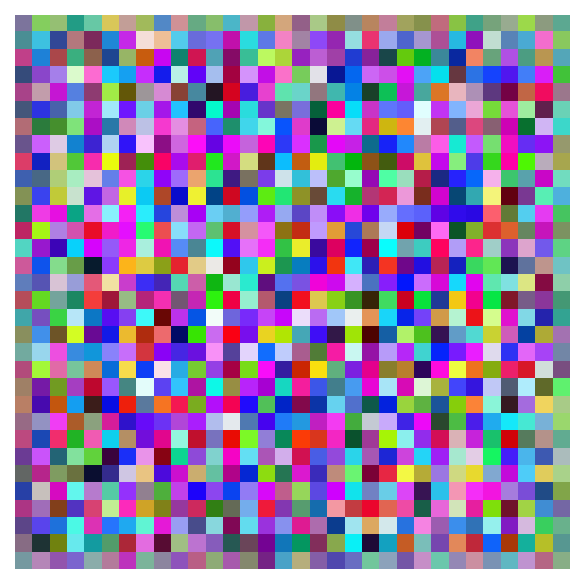

In [11]:
visualize_batch(G(latent))

In [12]:
# The shape of the tensor as it flows through the generator architecture
x = latent
for i in range(4):
    x = G.model[i](x.cuda())
    b, c, w, h = x.shape
    
    print(f"Channels: {c:3d}, w x h: {w:2d} x {h:2d}")

Channels: 256, w x h:  4 x  4
Channels: 128, w x h:  8 x  8
Channels:  64, w x h: 16 x 16
Channels:   3, w x h: 32 x 32


In [13]:
# Discriminator
D = (Discriminator (
    CONFIG["image_size"],
    CONFIG["d_feat_map_size"],
    CONFIG["num_channels"],
    dropout=0.1
).to(device))

In [14]:
print(D)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): Dropout(p=0.1, inplace=False)
      (2): Identity()
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout(p=0.1, inplace=False)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): Dropout(p=0.1, inplace=False)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 1, kernel_size=(4, 4), stride=(1, 1))
      (1): Identity()
      (2): Identity()
    

In [15]:
x = fake_img
for i in range(4):
    x = D.model[i](x)
    b, c, w, h = x.shape
    
    print(f"Channels: {c:3d}, w x h: {w:2d} x {h:2d}")

Channels:  64, w x h: 16 x 16
Channels: 128, w x h:  8 x  8
Channels: 256, w x h:  4 x  4
Channels:   1, w x h:  1 x  1


In [16]:
# Loss and optimizers
criterion = nn.BCELoss() # Binary Cross Entropy loss function

# Optimizer for the Generator
optimizerG = optim.Adam(
    G.parameters(), 
    lr=CONFIG["lr"], 
    betas=(CONFIG["beta1"], 0.999)
)

# Optimizer for the Discriminator
optimizerD = optim.Adam(
    D.parameters(), 
    lr=CONFIG["lr"] / 4, 
    betas=(CONFIG["beta1"], 0.999)
)

In [17]:
ema_G = EMA(
    G,
    beta = 0.995,              # average over the last ~10 epochs
    update_after_step = 100,    # start averaging after the first 5 epochs
    update_every = 1
)

In [18]:
# Training loop

# Initialize weights
_ = G.apply(initialize_weights)
_ = D.apply(initialize_weights)

In [19]:
# Create batch of latent vectors that we will use to visualize
# the progression of the generator
fixed_noise = torch.randn(16, CONFIG['latent_dimension'], 1, 1, device=device)

# Lists to keep track of progress
G_losses = []
D_losses = []
D_acc = []

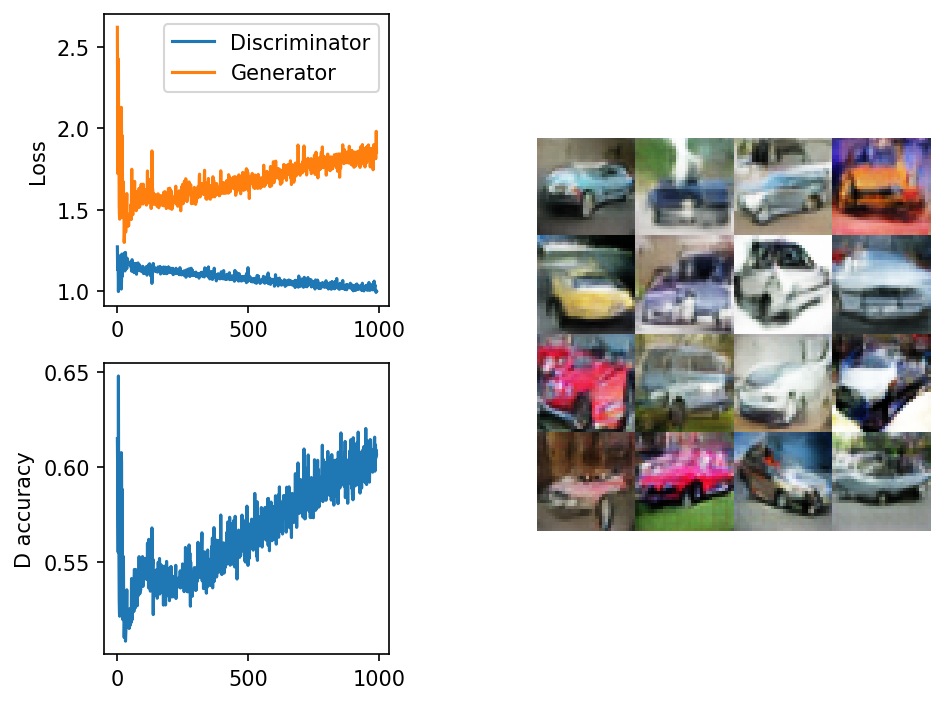

100%|██████████| 24/24 [00:00<00:00, 29.55it/s]

Finished in 14.1 min


In [20]:
print("Starting Training Loop...")

tstart = time.time()
n_frame = 0

for epoch in range(CONFIG['n_epochs']):
    
    # Keep track of losses and accuracy of the Discriminator
    # for each batch, we will average them at the end of the
    # epoch
    batch_G_losses = []
    batch_D_losses = []
    batch_D_acc = []
    
    # Loop over batch of real data (we throw away the labels
    # provided by the dataloader by saving them into `_`)
    for data, _ in tqdm.tqdm(dataloader, total=len(dataloader)):
        
        # Move batch to GPU and record its size
        # (remember that the last batch could be smaller than batch_size)
        data = data.to(device)
        b_size = data.size(0)
        
        # This function implements tricks 3 and 4 (smoothing and random label flipping)
        labels = get_positive_labels(b_size, device, smoothing=True, random_flip=0.2)
        
        ################################################
        # Discriminator training                       #
        ################################################
        
        D.zero_grad()
        
        # Forward pass real batch through D using DiffAugment
        # augmentation
        D_pred = D(
            DiffAugment(data, policy=CONFIG["policy"])
        ).view(-1)

        # Measure accuracy for the positive batch
        acc_pos = (D_pred > 0.5).sum() / D_pred.size(0)
        # Loss on the real data
        
        loss_on_real_data = criterion(D_pred, labels)
        # This computes the gradients after the real data
        # forward pass and store them in the tensors
        # (model parameters are NOT updated here)
        loss_on_real_data.backward()

        # Now pass a batch of fake data through the model
        # Generate batch of latent vectors
        latent_vectors = torch.randn(b_size, CONFIG['latent_dimension'], 1, 1, device=device)
        # Generate fake image batch with G
        fake_data = G(latent_vectors)
        # Assign negative label
        labels.fill_(0)  # 0 is the label for fake images

        # Get predictions from the Discriminator
        # (applying DiffAugment augmentations)
        # NOTE: here it is VERY important to use .detach() on the (augmented)
        # fake data because we do NOT want the Generator to be part of the computation
        # graph used to compute the gradients (we don't want to update the Generator yet)
        D_pred = D(
            DiffAugment(
                fake_data, 
                policy=CONFIG["policy"]
            ).detach()
        ).view(-1)

        # Get accuracy for this all-fake batch
        acc_neg = (D_pred < 0.5).sum() / D_pred.size(0)

        # Loss on fake data
        loss_on_fake_data = criterion(D_pred, labels)
        # This computes the gradients after the fake data
        # forward pass and stores them in the tensors
        # (model parameters are NOT updated here)
        # Remember that .backward() by default does NOT replace
        # the gradients coming from the backward pass on the real data.
        # Instead, it sums the new gradients with the old gradients
        loss_on_fake_data.backward()

        # Compute error of D as sum over the fake and the real batches
        # for safekeeping
        total_loss = loss_on_real_data + loss_on_fake_data
                
        # Now we can finally update the Discriminator
        optimizerD.step()

        ################################################
        # Generator training                           #
        ################################################
        G.zero_grad()
        
        # Remember that BCELoss is −[y logx + (1−y)⋅log(1−x)]
        labels.fill_(1)  # 1 is the label for "real".
        # Since we just updated D, perform another forward pass of
        # the all-fake batch we already generated as part of the previous
        # part (with DiffAugment)
        # NOTE how we are NOT using .detach now, as this time we want the
        # gradients for this operation to be accumulated
        D_pred = D(
            DiffAugment(
                fake_data, 
                policy=CONFIG["policy"]
            )
        ).view(-1)
        
        # Loss from the Discriminator prediction that is going
        # to be used to update G
        loss_on_fake_G = criterion(D_pred, labels)
        
        # Calculate gradients for G
        loss_on_fake_G.backward()
                
        # Update G
        optimizerG.step()
        
        # Update the Exponential Moving Average copy
        ema_G.update()
        
        # Save all losses
        batch_G_losses.append(loss_on_fake_G.item())
        batch_D_losses.append(total_loss.item())
        batch_D_acc.append((0.5 * (acc_pos + acc_neg)).item())
    
    # Take the mean over the epoch
    G_losses.append(np.mean(batch_G_losses))
    D_losses.append(np.mean(batch_D_losses))
    D_acc.append(np.mean(batch_D_acc))

    if epoch % CONFIG["save_iter"] == 0:
        with torch.no_grad():
            fake_viz_data = G(fixed_noise).detach().cpu()

        clear_output(wait=True)

        fig = training_tracking(D_losses, G_losses, D_acc, fake_viz_data)

        plt.show()
        
        fig.savefig(f"{CONFIG['outdir']}/frame_{n_frame:05d}.png")
        n_frame += 1

print(f"Finished in {(time.time() - tstart)/60:.1f} min")